# TP 6 Réseaux de neurones - Multi classification et Propagation en arrière
Dans ce TP, nous aimerions entrainer un réseau de neurones pour la tâche de classification en utilisant l'algorithme d propagation en arrière (backpropagation).

L'ensemble de données que nous allons utiliser est le même que celui utilisé durant le TP1, i.e. les images de chiffres manuscrits.


# Importation des librairies necessaires au travail

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import cv2 

# Lecture des fichiers de données
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [2]:
# données
data = np.genfromtxt('data.csv', delimiter=',', dtype=float)
data.shape

(5000, 401)

Dans ces données (data), les 400 premières colonnes representent les pixels de l'image (20x20), la dernière colonne represente la classe de l'image (chiffres de 0 à 9). (http://yann.lecun.com/exdb/mnist/)

Chaque ligne represente un exemple de notre ensemble de données. 

Mettons ces données dans leus vecteurs correspondants.

In [3]:
# rajoutons l'ordonnée à l'origine theta 0
intercept=np.ones((data.shape[0],1))
X=np.column_stack((intercept,data[:,:-1]))
y=data[:,-1]
# forcer y à avoir une seule colonne
y = y.reshape( y.shape[0], 1)

In [4]:
print('X', X.shape ,' y ', y.shape)

X (5000, 401)  y  (5000, 1)


Visualisation aléatoire de quelques données

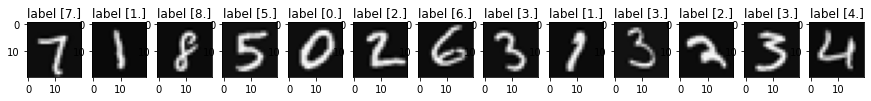

In [5]:
plt.figure(figsize=(15,8))
for i in range(13):
    c = random.randint(X.shape[0])
    a = X[c,1:].reshape((20, 20))
    a=np.transpose(a)
    plt.subplot(1,13,i+1)
    plt.title('label '+ str(y[c]))
    plt.imshow(a,cmap='gray')

Transformer y de tel sorte à avoir un vecteur pour chaque exemple

Equivalent de tocategorical

In [6]:
YY=np.zeros((y.shape[0], int(np.max(y))+1))
YY.shape

(5000, 10)

In [7]:
for i in range (YY.shape[0]):
    YY[i,int(y[i])]=1

# Réseaux de neurones
Pour cette partie, nous choisissons une réseau simple:

- une couche d'entrée avec 400 noeuds (20 x 20 pixels) + le biais
- une couche cachée avec 25 noeuds
- une couche de sortie avec 10 noeuds (nombre de classes)

In [8]:
# # poids de la couche 1
# W1 = np.genfromtxt('W1.csv', delimiter=',', dtype=float)
# W1.shape


In [9]:
# # poids de la couche 2
# W2 = np.genfromtxt('W2.csv', delimiter=',', dtype=float)
# W2.shape

In [10]:
input_layer_size  = 400;  
hidden_layer_size = 25;   
num_labels = 10;

# Calcul du coût

# TODO  1 calcul du coût
**Tâche 1**: Modifier la fonction computeCost afin d'obtenir un coût avec régularisation

Rappelons que le coût avec régularisation est calculé comme suit:

$ J(\theta)= \frac{1}{m} \sum_{i=1}^m\sum_{k=1}^K \left[ -y_k^{(i)} \log (h_\theta(x^{(i)}) )_k - (1-y_k^{(i)}) \log (1-h_\theta(x^{(i)}) )_k \right] + \frac{\lambda}{2m} \left[ \sum_{j=1}^{25}\sum_{k=1}^{400} \left( \theta_{j,k}^{(1)} \right)^2 +   \sum_{j=1}^{10}\sum_{k=1}^{25} \left( \theta_{j,k}^{(2)} \right)^2 \right] $

In [11]:
def Sigmoid(z):
    # pour une valeur donnée, cette fonction calculera sa sigmoid
    return 1/(1+np.exp(-z));

In [12]:
def computeCost(X, YY, theta1, theta2,hidden_layer_size, lambda_):
    a1=X; 

    z2= np.zeros((X.shape[0],hidden_layer_size))
    a2= np.zeros((X.shape[0],hidden_layer_size)) 

    intercept=np.ones((X.shape[0],1))
    
    d = np.matmul(a1,theta1)
    
    
    z2=np.column_stack((intercept,d))
    a2=Sigmoid(z2)
    a2[:,0]=1

    z3= np.zeros((YY.shape[0],YY.shape[1]))    
    a3= np.zeros((YY.shape[0],YY.shape[1]))  
    
    z3=np.matmul(a2[:,1:],theta2)
    intercept2=np.ones((X.shape[0],1))
    z3=np.column_stack((intercept2,z3))
    a3=Sigmoid(z3)

    J=np.zeros((YY.shape[0],1))
    J= (1/y.shape[0])*(np.sum(np.sum((-YY*np.log(a3))-((1-YY)*np.log(1-a3)))));

    return J

In [13]:
def computeCostReg(X, YY, theta1, theta2,hidden_layer_size, lamda):
    a1=X; 
    #a1 c'est l'activation de la premiere couche
    z2= np.zeros((X.shape[0],hidden_layer_size))
    a2= np.zeros((X.shape[0],hidden_layer_size)) 

    intercept=np.ones((X.shape[0],1))
    
    d = np.matmul(a1,theta1)
    
    
    z2=np.column_stack((intercept,d))
    a2=Sigmoid(z2)
    a2[:,0]=1

    z3= np.zeros((YY.shape[0],YY.shape[1]))    
    a3= np.zeros((YY.shape[0],YY.shape[1]))  
    
    z3=np.matmul(a2[:,1:],theta2)
    intercept2=np.ones((X.shape[0],1))
    z3=np.column_stack((intercept2,z3))
    a3=Sigmoid(z3)

    J=np.zeros((YY.shape[0],1))
    J= (1/y.shape[0])*(np.sum(np.sum((-YY*np.log(a3))-((1-YY)*np.log(1-a3)))));
    J+= (lamda/(2*y.shape[0]))*(np.sum(np.exp(theta1,2))+np.sum(np.exp(theta2,2)))

    return J

# TODO  2 calcul du gradient
**Tâche 2**: Implémenter la fonction NNCostFunction afin de retourner:

- Le coût avec régularisation
- Le gardient du coût par rapport à chaqu'un des paramètres du réseau

Rappelons le gradient de la sigmoid:

$ sigmoid(z) =\sigma(z)= \frac{1}{1-e^{-z}}$

$ \sigma(z)^\prime = \sigma(z)(1-\sigma(z)) =a(1-a)$ tel que $a$ est l'activation d'une couche donnée

L'algorithme à implementer est comme suit:

Pour chaque exemple de l'ensemble d'apprentissage faire

Pour chaque noeud de la couche de sortie, calculer la dérivée (gradient):

$\delta_k^{(3)} = \left( a_k^{(3)}- y_k \right)  $

Pour chaque noeud de la couche caché calculer la dérivée (gradient):

$\delta^{(2)} =  \left(\Theta^{(2)}\right)^T \delta^{(3)} \quad .* \quad \sigma^\prime\left(z^{(2)} \right) $

Notons que l'opérateur $.*$ represente la multiplication élement par élement et non pas la multiplication matricielle

Le gradient de chaque noeud et de chaque couche sera finalement:

$\Delta^{(l)} =  \Delta^{(l)} + \delta^{(l)} * \left( a^{(l)} \right)^T $

Fin pour

Fin pour

Diviser le gradient cumulé par le nombre d'exemples:

$ \frac{\partial J(\Theta)} { \partial \Theta_{i,j)}^{(l)}} = \frac{1}{m} \Delta_{i,j)}^{(l)}$


In [14]:
def sigmoid_prime(x):
    return Sigmoid(x)*(1.0-Sigmoid(x))

In [15]:
def NNCostFunction(X, YY, theta1, theta2,hidden_layer_size):
    theta1_grad = np.zeros((theta1.shape[0],theta1.shape[1]))
    theta2_grad = np.zeros((theta1.shape[0],theta1.shape[1]))

    Z1 = np.dot(X, theta1)
    A1 = Sigmoid(Z1)

    # on output layer
    Z2 = np.dot(A1, theta2)
    A2 = Sigmoid(Z2)
    
    
    # Calculating error
    lambda_ = 1
    
    J = computeCost(X, YY, theta1, theta2,hidden_layer_size, lambda_)
    
    
    # backpropagation
    E1 = A2 - YY
    dW1 = E1 * A2 * (1 - A2)

    E2 = np.dot(dW1, W2.T)
    dW2 = E2 * A1 * (1 - A1)

    return J, dW1,dW2,A1

# TODO  3 entrainement du réseau
**Tâche 3**: Entrainer le réseau en utilisant la descente du gradient:
Ici il faudra reprendre l'algorithme de la descente du gradient afin de mettre à jour les paramètres du réseau


In [16]:
def gradientDescent(X, y, W1, W2, alpha, iterations):
    for i in range(iterations):
        j,d1,d2,A1 = NNCostFunction(X, y, W1, W2,hidden_layer_size)
        N = X.shape[0]
        W2_update = np.dot(A1.T, d1) / N
        W1_update = np.dot(X.T, d2) / N

        W2 = W2 - alpha * W2_update
        W1 = W1 - alpha * W1_update
        costs.append(j)
    

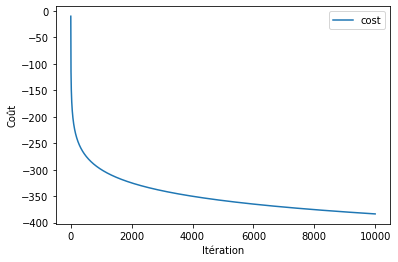

In [17]:
alpha = 0.1
iterations = 10000


# number of input features
input_size = X.shape[1]

# number of hidden layers neurons
hidden_layer_size = 25

# number of neurons at the output layer
output_size = 10  

np.random.seed(10)

# initializing weight for the hidden layer
W1 = np.random.normal(scale=0.5, size=(input_size, hidden_layer_size))   

# initializing weight for the output layer
W2 = np.random.normal(scale=0.5, size=(hidden_layer_size , output_size)) 
costs =  []

gradientDescent(X, y, W1, W2, alpha, iterations)

x = [i for i in range(iterations)]
plt.plot(x, costs, label='cost')

plt.xlabel('Itération')
plt.ylabel('Coût')
plt.legend(loc='best')
plt.show()

# TODO 4 : Régularisation
Mettre à jour le calcul du coût en ajoutant le terme de régularisation et comparer les résultats (avec et sans régularisation)

In [27]:
def NNCostFunctionReg(X, YY, theta1, theta2,hidden_layer_size):
    theta1_grad = np.zeros((theta1.shape[0],theta1.shape[1]))
    theta2_grad = np.zeros((theta1.shape[0],theta1.shape[1]))

    Z1 = np.dot(X, theta1)
    A1 = Sigmoid(Z1)

    # on output layer
    Z2 = np.dot(A1, theta2)
    A2 = Sigmoid(Z2)
    
    
    # Calculating error
    lambda_ = 1
    
    J = computeCostReg(X, YY, theta1, theta2,hidden_layer_size, lambda_)
    
    
    # backpropagation
    E1 = A2 - YY
    dW1 = E1 * A2 * (1 - A2)

    E2 = np.dot(dW1, W2.T)
    dW2 = E2 * A1 * (1 - A1)

    return J, dW1,dW2,A1

In [28]:
def gradientDescentReg(X, y, W1, W2, alpha, iterations):
    for i in range(iterations):
        j,d1,d2,A1 = NNCostFunctionReg(X, y, W1, W2,hidden_layer_size)
        N = X.shape[0]
        W2_update = np.dot(A1.T, d1) / N
        W1_update = np.dot(X.T, d2) / N

        W2 = W2 - alpha * W2_update
        W1 = W1 - alpha * W1_update
        costs.append(j)

# TODO 5 : Prédiction

Appliquer une propagation en avant en utilisant les paramètres données pour prédir les classes de l'ensemble d'apprentissage.



In [18]:
def chooseMax(Y):
    z = np.ones(Y.shape[0])
    for i in range(Y.shape[0]):
        z[i] = np.argmax(Y[i])
  
    return z

In [19]:
def predict (W1, W2, X):
    Z1 = np.dot(X, W1)
    A1 = Sigmoid(Z1)

    # on output layer
    Z2 = np.dot(A1, W2)
    A2 = Sigmoid(Z2)
    # appliquer une propagation en avant
    # !--- n'oubliez pas d'appliquer la sigmoid à chaque couche afin d'avoir les probabilités ---!
    
    # prédire la classe en choisissant la probabilité maximale parmi les 10 noeuds de sortie
    y_pred = chooseMax(A2)
    return y_pred

In [20]:
def reshape(y):

    z = np.ones(y.shape[0])
    for i in range(y.shape[0]):
        z[i] = y[i][0].item()
    
    z.reshape(y.shape[0],1)
    return z

In [21]:
# calcul de precision = nombre de valeurs bien prédites (ici sur toute la base X)
y_pred=predict(W1, W2, X)
print(y_pred.shape)
print(y_pred[:5])
y = reshape(y)
print(y.shape)
print(y[:5])
y
precision = np.mean(y==y_pred)*100
precision

(5000,)
[3. 3. 1. 3. 3.]
(5000,)
[0. 0. 0. 0. 0.]


12.6

# optionnel 1 : Vérification de l'implementation
Comparer vos algorithmes à ceux de scikitlearn

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(data[:,:-1], data[:,-1], test_size = 0.20)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

mlp = MLPClassifier(hidden_layer_sizes=(25), max_iter=10000)
mlp.fit(X_train, y_train)

predictions = mlp.predict(X_test)

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[87  0  1  1  0  0  0  0  1  0]
 [ 0 93  0  0  1  1  0  1  2  0]
 [ 1  0 77  2  4  0  1  1  3  0]
 [ 0  1  2 99  1  3  0  1  1  1]
 [ 0  0  0  0 92  0  1  0  1  3]
 [ 1  1  2  4  1 98  1  1  3  2]
 [ 0  1  0  0  2  4 99  0  1  0]
 [ 2  0  2  2  1  0  0 84  0  4]
 [ 2  0  1  2  2  4  3  0 82  1]
 [ 0  2  1  0  0  2  1  0  0 98]]
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95        90
         1.0       0.95      0.95      0.95        98
         2.0       0.90      0.87      0.88        89
         3.0       0.90      0.91      0.90       109
         4.0       0.88      0.95      0.92        97
         5.0       0.88      0.86      0.87       114
         6.0       0.93      0.93      0.93       107
         7.0       0.95      0.88      0.92        95
         8.0       0.87      0.85      0.86        97
         9.0       0.90      0.94      0.92       104

    accuracy                           0.91      1000
   macro avg       

# Optionnel 2 : Visualisation des poids
    
La visualisation de poids permet de voir quel partie du réseau est activé et pour quelle classe.
Il est possible de visulaiser les paramètres theta1 . 
Ceci peut se faire en utilisant un reshape de ces paramètres afin d'avoir 25 images de taille 20x20 (n'oubliez pas d'ignorer la premuère colonne, celle du biais)

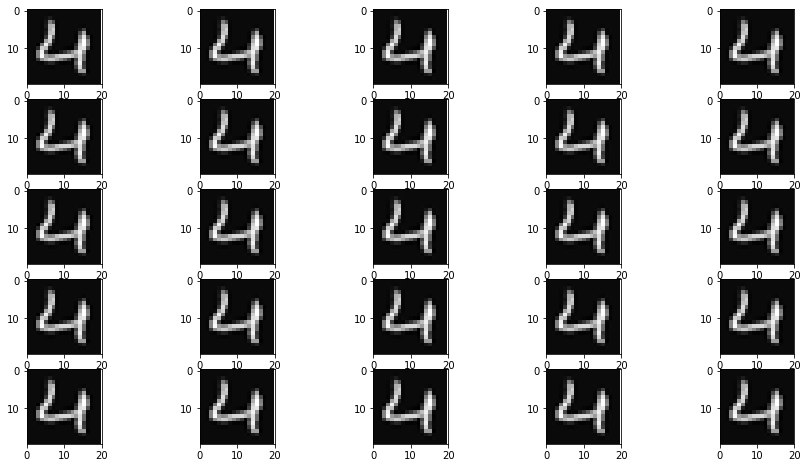

In [26]:
theta1 =np.transpose(W1)
plt.figure(figsize=(15,8))
for i in range(5):
    for j in range(5):
        e = theta1[i*5+j,1:].reshape((20, 20))
        plt.subplot(5,5,i*5+j+1,xlim=(0,20))
        plt.imshow(a,cmap='gray')

# Optionnel 3 : Renforcement de l'apprentissage
Mettre ici toute idée qui pourrait renforcer votre apprentissage

# Consignes

Le travail est à remettre par groupe de 4 au maximum [1..4].

Le délai est le vendredi 29Avril 2022 à 22h


In [ ]:
# bonne chance